# Building Micrograd - Part 2

From this lecture: https://www.youtube.com/watch?v=VMj-3S1tku0

Micrograd is a neural network library that uses the neural network system to build mathematical functions, and can be used to find the derivatives of variables relative to wher ethe backpropagation was formed. You can find more out abotu micrograd here: https://github.com/karpathy/micrograd

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Value object

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children) 
        self._op = _op 
        self.label = label
        self.grad = 0.0 
        self._backward = lambda: None 

    def __repr__(self) -> str:
        return f"Value(data={self.data})" 
    
    def __add__(self, other):
        # Ensure that other is a Value, so we can do a + 1
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') 
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    # At present, a + 2 works but not 2 + a as integers don't have Value in their addition method
    # So we can use the __radd__ method to handle this, as when the integer's add fails,
    def __radd__(self, other):
        return self.__add__(other)
    
    def __sub__(self, other): # self - other
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __neg__(self): # -self
        return self * -1
    
    def __mul__(self, other):
        # Ensure that other is a Value, so we can do a * 1
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out
    
    # At present, a * 2 works but not 2 * a as integers don't have Value in their multiplication method
    # So we can use the __rmul__ method to handle this, as when the integer's mul fails,
    # it will try to call the Value's rmul method instead
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        # The derivative of e^x is e^x (fun!)
        def _backward():
            self.grad += out.data * out.grad # out.data is e^x
        out._backward = _backward
        return out
    
    # Our backwards pass
    def backward(self):
        self.grad = 1
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [3]:
# Tests for our new implementation
a = Value(2.0)
print(f'{a * 2=}')
print(f'{2 * a=}')
print(f'{(a.exp()).data=}')

a * 2=Value(data=4.0)
2 * a=Value(data=4.0)
(a.exp()).data=7.38905609893065


In [4]:
# Let's add in some visualisation
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
# Reset the data
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
# Add together
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# add bias
n = x1w1x2w2 + b; n.label = 'n'
# activation
o = n.tanh(); o.label = 'o'

o.backward()

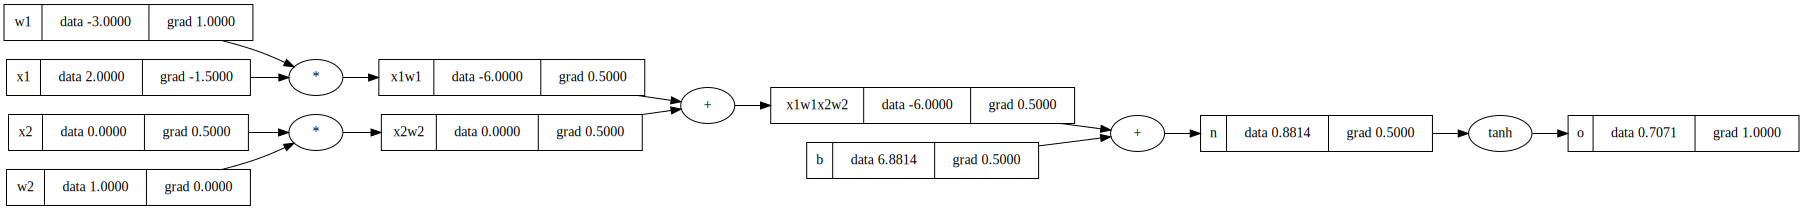

In [6]:
draw_dot(o)

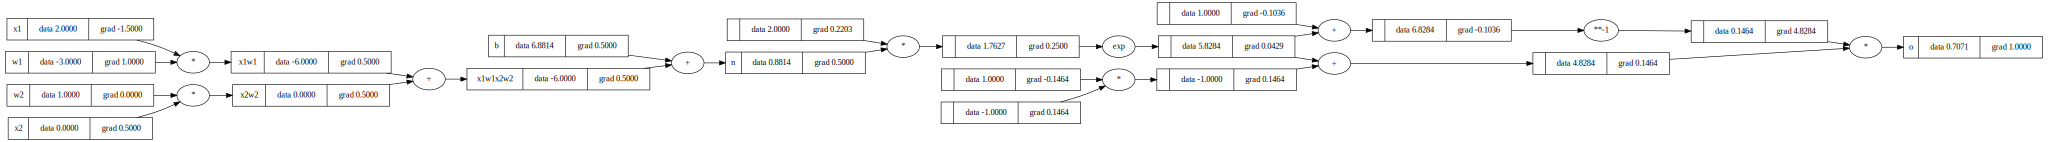

In [7]:
# Reset the data
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
# Add together
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# add bias
n = x1w1x2w2 + b; n.label = 'n'
# let's break down the tanh
e = (2*n).exp()
o = (e-1)/(e+1)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

Looks like expanding the tanh was correct, as our backward pass, while expanded, produced the same gradient sfor the common nodes between the prior method and this one.

## PyTorch API

Let's replicate htis in PyTorch API

In [8]:
import torch

We are just using scalar tensors. We would usually use far more complicated tensors.

In [9]:
# Casting to double as default in pytorch is float64
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # let torch knopw that we want to calculate the gradient
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True # They are set to false by default due to memory constraints
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # .item() to get the value of a tensor
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


/home/ed/anaconda3/envs/micrograd_3_12/lib/python3.12/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


PyTorch agrees with our gradients!

## Build out a neural network

In [10]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # zip takes two iterables and returns an iterator of tuples
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b, but a more efficient way is
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # as the second argument of sum is the starting point
        # activation function
        out = act.tanh()
        return out
    
    # this method returns all the parameters of the neuron 
    def parameters(self):
        return self.w + [self.b]

# We can now forward a single neuron.

class Layer:
    #  a layer is a collection of neurons, here a list
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # if there is only one neuron, return it, otherwise return all
    
    # this method returns all the parameters of the layer
    def parameters(self):
        # params = []
        # for n in self.neurons:
        #     ps = n.parameters()
        #     params.extend(ps)
        # return params
        return [p for n in self.neurons for p in n.parameters()] # this is the same as the commented code above
    

class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs # this is the size of the network
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)] # create the layers

    def __call__(self, x):
        # we just call them sequentially
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [11]:
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))


x = [2.0, 3.0]
n = Layer(2, 3)
print(n(x))


x = [2.0, 3.0, -1.0]
# first hidden layer has 4 neurons, second has 4, and the output has 1
n = MLP (3, [4, 4, 1])
print(n(x))

Value(data=0.11119052314630955)
[Value(data=0.7994053597445148), Value(data=-0.6870684741252621), Value(data=0.5231694220760102)]
Value(data=0.99277186436696)


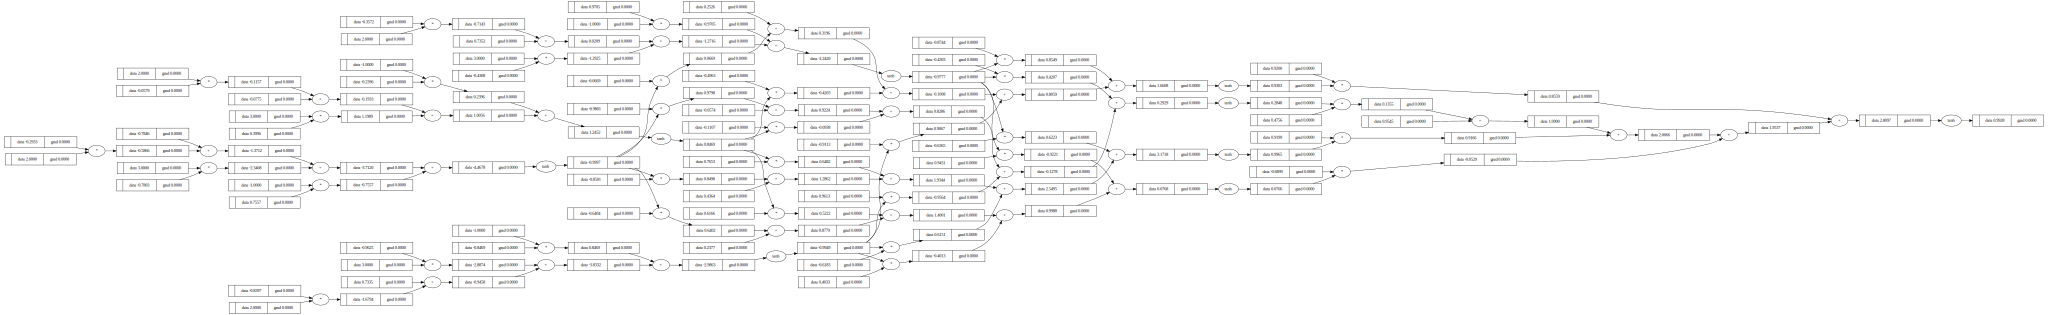

In [12]:
draw_dot(n(x))

This is an entire MLP!

## Creating a tiny data set

In [13]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.99277186436696),
 Value(data=0.9261322775253664),
 Value(data=0.8514552992669264),
 Value(data=0.9904709751430399)]

We have our values off from our labels. So we should get a value to represent how well the model performs. This is the loss.

In [14]:
# mean squared error loss (MSE)
loss = sum((y - p) ** 2 for y, p in zip(ys, ypred)) # (y - ypred)^2
loss

Value(data=7.1380153239680935)

In [15]:
# backward pass is easy
loss.backward()

In [16]:
n.layers[0].neurons[0].w[0].grad

-0.8404522432098257

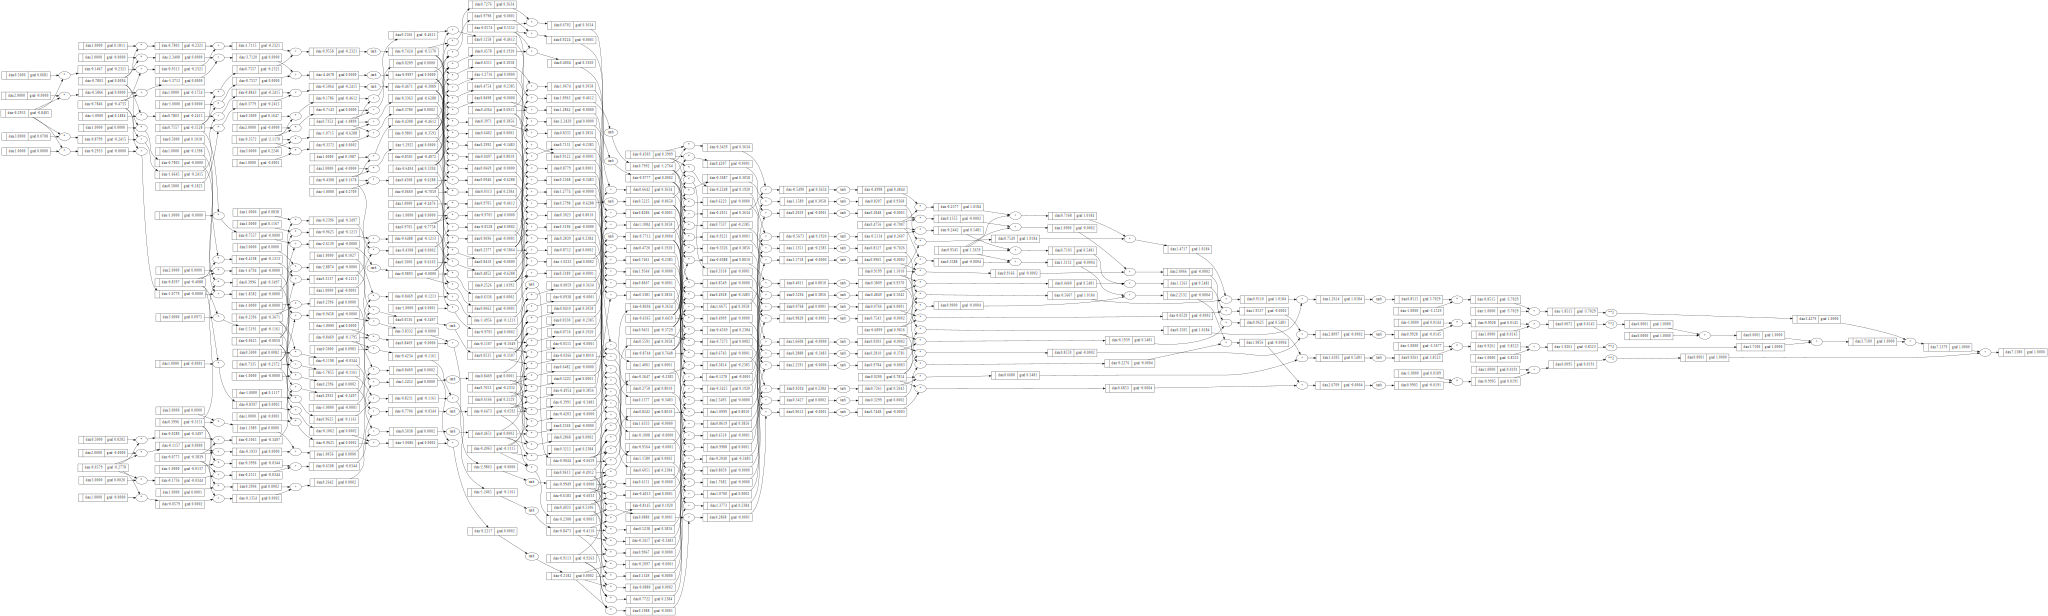

In [17]:
draw_dot(loss)

Note that we do not change the gradients of any of the inputs, as they are static. So while we do calculate the gradients, we ignore them, and it is the weights that shift their gradients, as we can change these.

In [18]:
# These are all the weights and biases of the network
n.parameters()

[Value(data=-0.29331223045134247),
 Value(data=-0.7802757726187393),
 Value(data=0.7557354549286102),
 Value(data=-0.784595716563913),
 Value(data=-0.05786915460240505),
 Value(data=0.3996318720671288),
 Value(data=-0.23959869489865437),
 Value(data=-0.07751737007728643),
 Value(data=-0.8396865163042655),
 Value(data=-0.9624523926794595),
 Value(data=-0.8468724061387736),
 Value(data=0.7335337424759514),
 Value(data=-0.3571542687432947),
 Value(data=-0.4308191527458072),
 Value(data=0.9704575783668099),
 Value(data=0.7351950169116652),
 Value(data=-0.9800756825890484),
 Value(data=-0.1106924770152593),
 Value(data=0.9613025703669416),
 Value(data=-0.4303104172600687),
 Value(data=-0.057446371732577495),
 Value(data=-0.8500615563451128),
 Value(data=0.7653386670463471),
 Value(data=-0.6182550662195962),
 Value(data=-0.6364948076805388),
 Value(data=0.43636693626235723),
 Value(data=-0.6404098396135973),
 Value(data=0.6165771323060263),
 Value(data=0.4033024040337423),
 Value(data=0.9431

In [19]:
len(n.parameters())

41

In [20]:
n.layers[0].neurons[0].w[0].grad

-0.8404522432098257

In [21]:
n.layers[0].neurons[0].w[0].data

-0.29331223045134247

In [22]:
# Let's update the weights
lr = 0.01 # if the learning rate is too high, the network will diverge as we will overstep the minimum
for p in n.parameters():
    p.data -= lr * p.grad

# For gradient descent, we think of gradient as a vector pointing to increasing the loss, so we subtract it from the weights

In [24]:
n.layers[0].neurons[0].w[0].grad

-0.8404522432098257

In [23]:
n.layers[0].neurons[0].w[0].data

-0.2849077080192442

A slight increase, menaing that the loss will go down. Let's check, last loss was Value(data=7.1380153239680935)

In [26]:
ypred = [n(x) for x in xs]
# mean squared error loss (MSE)
loss = sum((y - p) ** 2 for y, p in zip(ys, ypred)) # (y - ypred)^2
loss

Value(data=6.913086045604511)

Yes, a small decrease, the network as learned! Loss loss means our predictions are matching the targets better.

This is gradient descent:
- forward pass
- backward pass
- update

# Implement a training loop

Let's reset with the data

In [27]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [28]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((y - p) ** 2 for y, p in zip(ys, ypred)) # (y - ypred)^2
    # backward pass
    loss.backward()
    # update weights
    lr = 0.05
    for p in n.parameters():
        p.data -= lr * p.grad
    print(k, loss.data)

0 6.913086045604511
1 1.7212446162509463
2 0.30325103958992916
3 2.8040215897028666
4 0.003137880361297654
5 3.3192421446426236e-05
6 2.109811069470943e-06
7 2.2239290591178503e-06
8 0.26340919959875175
9 1.7652361031523162e-08
10 5.95521599243016e-09
11 2.541254847732705e-09
12 1.4126044688875433e-09
13 2.0883407607792355e-09
14 5.712425797676231e-08
15 7.717350966789292e-05
16 0.3708813894249423
17 2.908865533497e-12
18 5.275816325035064e-13
19 9.967694589430968e-14


In [29]:
ypred

[Value(data=0.9999997767126857),
 Value(data=-0.999999998985407),
 Value(data=-0.9999999990466674),
 Value(data=0.9999997768010239)]

## Correcting an error

We have an error. We are adding to .grad for eahc neurons, which solved the multiple calls to grad. But, for each training route when we update the gradients, we are adding to the gradients that existed before when we set them in the backwards pass! This needs to be corrected. Let's reset.

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((y - p) ** 2 for y, p in zip(ys, ypred)) # (y - ypred)^2
    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # reset the gradients
    loss.backward()
    # update weights
    lr = 0.05
    for p in n.parameters():
        p.data -= lr * p.grad
    print(k, loss.data)